On April 25th, 2022, I went climbing and fell and broke my leg. I had my Garmin watch on at the time, so I could see exactly what happened to my body, minute by minute. 

In [1]:
# Check out timestamps
import altair as alt
import datetime
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

alt.renderers.enable('mimetype')
alt.themes.enable('fivethirtyeight')

dfs = []
for filename in glob.glob('fit_processing/subject_data/patrick/fit_files/*.csv'):
    if 'records_data' in filename:
        continue
    df = pd.read_csv(filename)
    
    timestamp_locs = (df['Field 1'] == 'timestamp') & (df['Units 1'] == 's')
    timestamps = np.ones(df.shape[0]) * np.nan
    timestamps[timestamp_locs] = df[timestamp_locs]['Value 1'].values
    
    for i in range(2, 68):
        if f'Field {i}' in df.columns:
            timestamp_locs = (df[f'Field {i}'] == 'timestamp') & (df[f'Units {i}'] == 's')
            if np.any(timestamp_locs):
                timestamps[timestamp_locs] = df[timestamp_locs][f'Value {i}'].values
        else:
            break
    
    times = pd.Series(timestamps)
    times = times.ffill()
    df['times'] = times
    dfs.append(df)
    
df = pd.concat(dfs, axis=0)

/var/folders/vz/6yxqzl6j5g384z7j_3pj2p1m0000gn/T/ipykernel_95666/590341342.py:16: DtypeWarning: Columns (7,13,16,19,22,26,29,32,38,41,44,56,62,65,74,150,153,156,159,162,165,168,171,174,177,180,183,186,189,192,195,198,201) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)
/var/folders/vz/6yxqzl6j5g384z7j_3pj2p1m0000gn/T/ipykernel_95666/590341342.py:16: DtypeWarning: Columns (7,13,16,19,22,26,29,32,38,41,44,56,62,65,74,150,153,156,159,162,165,168,171,174,177,180,183,186,189,192,195,198,201) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)
/var/folders/vz/6yxqzl6j5g384z7j_3pj2p1m0000gn/T/ipykernel_95666/590341342.py:16: DtypeWarning: Columns (7,13,16,19,22,26,29,32,38,41,44,56,62,65,74,150,153,156,159,162,165,168,171,174,177,180,183,186,189,192,195,198,201) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)
/var/folders/vz/6yxqzl6j5

In [2]:
df.head()

,Type,Local Number,Message,Field 1,Value 1,Units 1,Field 2,Value 2,Units 2,Field 3,...,Value 67,Units 67,Unnamed: 204,Unnamed: 81,Unnamed: 21,Unnamed: 15,Unnamed: 18,Unnamed: 42,Unnamed: 36,Unnamed: 33
0,Definition,0,file_id,serial_number,1,NaN,time_created,1.0,NaN,manufacturer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Data,0,file_id,serial_number,3350125780,NaN,time_created,1012066740.0,NaN,manufacturer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Definition,1,device_info,timestamp,1,NaN,serial_number,1.0,NaN,manufacturer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Data,1,device_info,timestamp,1012066740,s,serial_number,3350125780.0,NaN,manufacturer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Definition,2,software,version,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# melt the dataframe
sub_dfs = []
for field_num in range(1, 68):
    sub_df = df[['times', f'Field {field_num}', f'Value {field_num}', f'Units {field_num}']].rename(
            columns={'times': 'timestamp',
                     f'Field {field_num}': 'field', 
                     f'Value {field_num}': 'value', 
                     f'Units {field_num}': 'units'}
    )
    
    sub_df = sub_df[~sub_df.field.isna()]
    sub_dfs.append(sub_df)
    
df_long = pd.concat(sub_dfs, axis=0)

Garmin indexes from Dec 31st, 1989 because reasons. 4 hours for EST offset.

In [4]:
delta = 631065600 - 3600 * 4
df_long = df_long[~df_long.timestamp.isna()]
df_long = df_long.sort_values('timestamp')
df_long['datetime'] = pd.to_datetime(df_long.timestamp + delta, unit='s')
df_long = df_long[(df_long.datetime >= datetime.datetime(2022, 1, 1)) & 
                  (df_long.datetime <= datetime.datetime(2023, 1, 1))]

Plot the heart rate on tht faithful day.

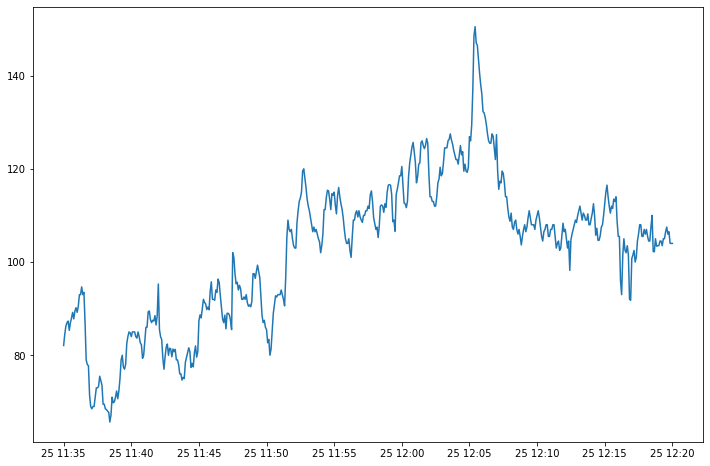

In [5]:
def clean_timeseries(df, freq='5s'):
    df = df.set_index(df.datetime)
    df.value = df.value.astype(float)
    df = df.resample(freq).mean().reset_index()
    df = df.interpolate('pad', limit=120)
    return df

plt.figure(figsize=(12, 8))

df_ = df_long[(df_long.datetime >= '2022-04-25 11:35') & (df_long.datetime <= '2022-04-25 12:20')]

df_plot = df_[df_.field == 'heart_rate']
df_plot = df_plot[df_plot.value.astype(float) > 10]

df_plot = clean_timeseries(df_plot)

plt.plot(df_plot.datetime, df_plot.value, '-')
#plt.ylim((0, 5))


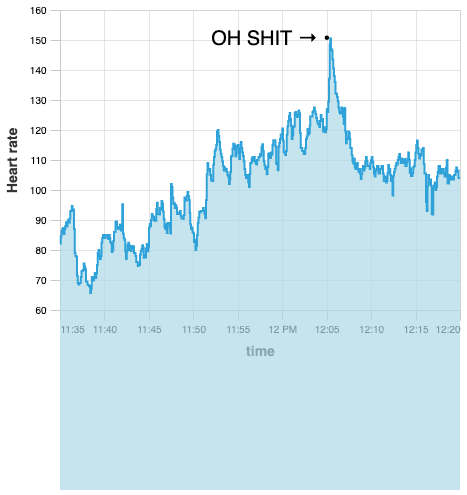

In [6]:
df_plot['text'] = ''
df_plot.loc[df_plot.value == df_plot.value.max(), 'text'] = 'OH SHIT → •'

chart = alt.Chart(df_plot)
(chart.mark_area(
    color="lightblue",
    interpolate='step-after',
    line=True,
).encode(
    x=alt.X('datetime', axis=alt.Axis(title='time')),
    y=alt.Y('value', scale=alt.Scale(domain=((60, 160))), axis=alt.Axis(title='Heart rate'))
) + chart.mark_text(align='right', size=20).encode(x='datetime', y='value', text='text')).configure(
    background='white',
).configure_axis(gridOpacity=.5, labelColor='black')

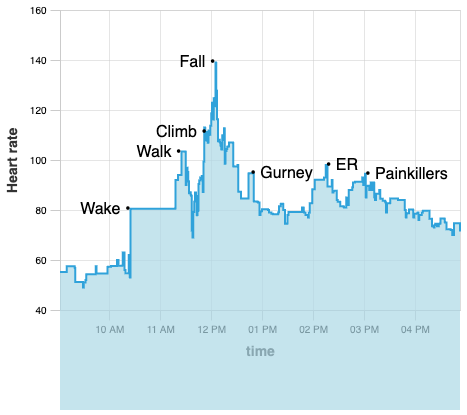

In [7]:
df_ = df_long[(df_long.datetime >= '2022-04-25 09:00') & (df_long.datetime <= '2022-04-25 17:00')]

df_plot = df_[df_.field == 'heart_rate']
df_plot = df_plot[df_plot.value.astype(float) > 10]

df_plot = clean_timeseries(df_plot, '1min')

df_plot['textright'] = ''
df_plot['textleft'] = ''
df_plot.loc[df_plot.value == df_plot.value.max(), 'textright'] = 'Fall •'
df_plot.loc[df_plot.datetime == '2022-04-25 11:25:00', 'textright'] = 'Walk •'
df_plot.loc[df_plot.datetime == '2022-04-25 11:55:00', 'textright'] = 'Climb •'
df_plot.loc[df_plot.datetime == '2022-04-25 10:25:00', 'textright'] = 'Wake •'
df_plot.loc[df_plot.datetime == '2022-04-25 12:46:00', 'textleft'] = '• Gurney'
df_plot.loc[df_plot.datetime == '2022-04-25 14:15:00', 'textleft'] = '• ER'
df_plot.loc[df_plot.datetime == '2022-04-25 15:01:00', 'textleft'] = '• Painkillers'

chart = alt.Chart(df_plot)
(chart.mark_area(
    color="lightblue",
    interpolate='step-after',
    line=True,
).encode(
    x=alt.X('datetime', axis=alt.Axis(title='time')),
    y=alt.Y('value', scale=alt.Scale(domain=((48, 160))), axis=alt.Axis(title='Heart rate'))
) + 
 chart.mark_text(align='right', size=16).encode(x='datetime', y='value', text='textright') + 
 chart.mark_text(align='left', size=16).encode(x='datetime', y='value', text='textleft')).configure(
    background='white',
).configure_axis(gridOpacity=.5, labelColor='black')

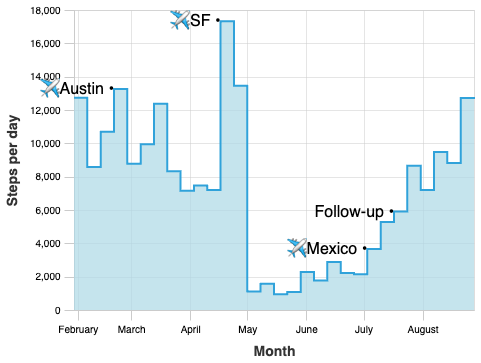

In [8]:
def clean_timeseries(df, freq='5s', agg='mean'):
    df = df.set_index(df.datetime)
    df.value = df.value.astype(float)
    if agg == 'mean':
        df = df.resample(freq).mean().reset_index()
    elif agg == 'sum':
        df = df.resample(freq).sum().reset_index()
    df = df.interpolate('pad', limit=120)
    return df

df_ = df_long[(df_long.datetime >= '2022-01-28 00:00') & (df_long.datetime <= '2022-08-28 00:00')]

df_plot = df_[df_.field == 'steps']
df_plot = df_plot.set_index(df_plot.datetime)
df_plot.value = df_plot.value.astype(dtype=float)
df_plot = df_plot.resample('1d', offset='1h').max()
df_plot = df_plot.resample('1w').mean().reset_index()

#df_plot = clean_timeseries(df_plot, '1d', agg='mean')

df_plot['textright'] = ''
df_plot['textleft'] = ''
df_plot.loc[df_plot.value == df_plot.value.max(), 'textright'] = '✈️SF •'
df_plot.loc[df_plot.datetime == '2022-02-20', 'textright'] = '✈️Austin •'
df_plot.loc[df_plot.datetime == '2022-07-03', 'textright'] = '✈️Mexico •'
df_plot.loc[df_plot.datetime == '2022-07-17', 'textright'] = 'Follow-up •'

chart = alt.Chart(df_plot)
(chart.mark_area(
    color="lightblue",
    interpolate='step-after',
    line=True,
).encode(
    x=alt.X('datetime', axis=alt.Axis(title='Month')),
    y=alt.Y('value', scale=alt.Scale(domain=((0, 18000))), axis=alt.Axis(title='Steps per day'))
) + 
 chart.mark_text(align='right', size=16).encode(x='datetime', y='value', text='textright') + 
 chart.mark_text(align='left', size=16).encode(x='datetime', y='value', text='textleft')).configure(
    background='white',
).configure_axis(gridOpacity=.5, labelColor='black')

/var/folders/vz/6yxqzl6j5g384z7j_3pj2p1m0000gn/T/ipykernel_95666/1115790320.py:24: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  df_plot_2 = df_plot_2.resample('1d', offset='1h').quantile(.05)


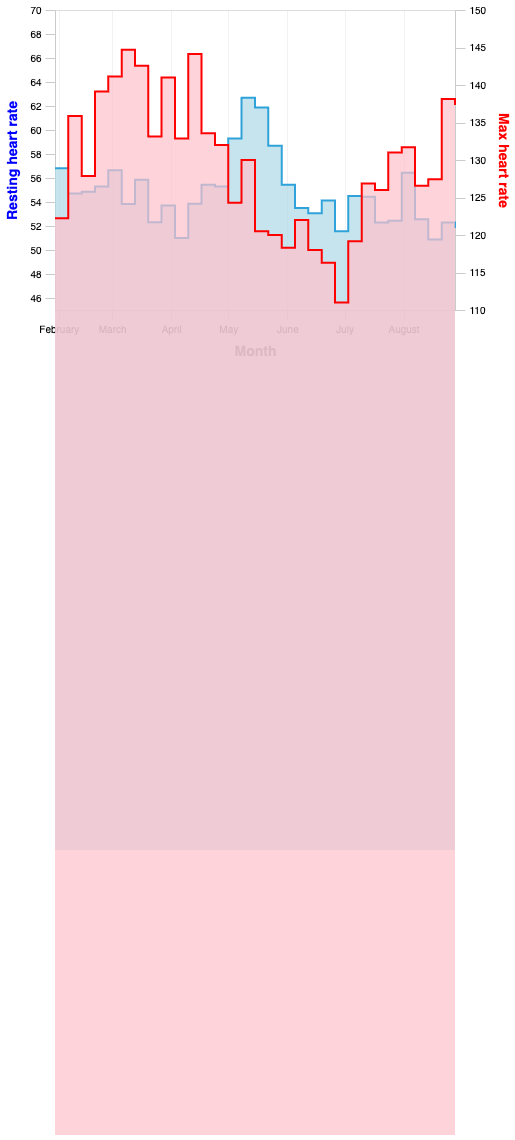

In [9]:
def clean_timeseries(df, freq='5s', agg='mean'):
    df = df.set_index(df.datetime)
    df.value = df.value.astype(float)
    if agg == 'mean':
        df = df.resample(freq).mean().reset_index()
    elif agg == 'sum':
        df = df.resample(freq).sum().reset_index()
    df = df.interpolate('pad', limit=120)
    return df

df_ = df_long[(df_long.datetime >= '2022-01-28 00:00') & (df_long.datetime <= '2022-08-28 00:00')]

df_plot = df_[df_.field == 'heart_rate']
df_plot = df_plot.set_index(df_plot.datetime)
df_plot.value = df_plot.value.astype(dtype=float)
df_plot = df_plot[df_plot.value > 15]
df_plot = df_plot.resample('1d', offset='1h').max()
df_plot = df_plot.resample('1w').mean().reset_index()

df_plot_2 = df_[df_.field == 'heart_rate']
df_plot_2 = df_plot_2.set_index(df_plot_2.datetime)
df_plot_2.value = df_plot_2.value.astype(dtype=float)
df_plot_2 = df_plot_2[df_plot_2.value > 15]
df_plot_2 = df_plot_2.resample('1d', offset='1h').quantile(.05)
df_plot_2 = df_plot_2.resample('1w').mean().reset_index()

df_plot['resting_heart_rate'] = df_plot_2.value

#df_plot = clean_timeseries(df_plot, '1d', agg='mean')

df_plot['textright'] = ''
df_plot['textleft'] = ''

chart = alt.Chart(df_plot)
top = chart.mark_area(
    color="lightblue",
    interpolate='step-after',
    line=True,
).encode(
    x=alt.X('datetime', axis=alt.Axis(title='Month')),
    y=alt.Y('resting_heart_rate', scale=alt.Scale(domain=((45, 70))), axis=alt.Axis(title='Resting heart rate', titleColor='blue'))
)
bottom = chart.mark_area(
    color="pink",
    interpolate='step-after',
    line={'color': 'red'},
).encode(
    x=alt.X('datetime', axis=alt.Axis(title='Month')),
    y=alt.Y('value', scale=alt.Scale(domain=((110, 150))), axis=alt.Axis(title='Max heart rate', titleColor='red'))
)
 
# chart.mark_text(align='right', size=16).encode(x='datetime', y='value', text='textright') + 
# chart.mark_text(align='left', size=16).encode(x='datetime', y='value', text='textleft')).configure(
#    background='white',
#)#
alt.layer(top, bottom).resolve_scale(
    y = 'independent'
).configure(background='white').configure_axis(gridOpacity=.25, labelColor='black')

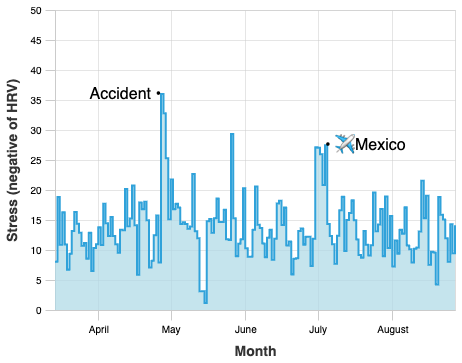

In [10]:
def clean_timeseries(df, freq='5s', agg='mean'):
    df = df.set_index(df.datetime)
    df.value = df.value.astype(float)
    if agg == 'mean':
        df = df.resample(freq).mean().reset_index()
    elif agg == 'sum':
        df = df.resample(freq).sum().reset_index()
    df = df.interpolate('pad', limit=120)
    return df

df_ = df_long[(df_long.datetime >= '2022-03-15 00:00') & (df_long.datetime <= '2022-08-28 00:00')]

df_plot = df_[df_.field == 'stress_level_value']
#df_plot = df_plot[df_plot.value >= 0]
df_plot = df_plot.set_index(df_plot.datetime)
df_plot.value = df_plot.value.astype(dtype=float)
df_plot = df_plot.resample('1d', offset='1h').mean()
df_plot = df_plot.resample('1d').mean().reset_index()
df_plot = df_plot[df_plot.value >= 0]

#df_plot = clean_timeseries(df_plot, '1d', agg='mean')

df_plot['textright'] = ''
df_plot['textleft'] = ''
df_plot.loc[df_plot.value == df_plot.value.max(), 'textright'] = 'Accident •'
df_plot.loc[df_plot.datetime == '2022-07-04', 'textleft'] = '• ✈️Mexico '

chart = alt.Chart(df_plot)
(chart.mark_area(
    color="lightblue",
    interpolate='step-after',
    line=True,
).encode(
    x=alt.X('datetime', axis=alt.Axis(title='Month')),
    y=alt.Y('value', scale=alt.Scale(domain=((0, 50))), axis=alt.Axis(title='Stress (negative of HRV)'))
) + 
 chart.mark_text(align='right', size=16).encode(x='datetime', y='value', text='textright') + 
 chart.mark_text(align='left', size=16).encode(x='datetime', y='value', text='textleft')).configure(
    background='white',
).configure_axis(gridOpacity=.5, labelColor='black')